# Aprendizaje Automatico - TP 1

In [1]:
%matplotlib inline

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time, strftime

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

In [4]:
import simple_features as sf
import email_text_retrieval as etr

#### Funciones Auxiliares

In [5]:
def load_data(max_rows_per_class=None, test_size=0.20):
    ham_txt = json.load(open('dataset/ham_dev.json'))
    spam_txt = json.load(open('dataset/spam_dev.json'))
    
    if max_rows_per_class is not None:
        ham_txt = ham_txt[1:max_rows_per_class]
        spam_txt = spam_txt[1:max_rows_per_class]
    
    df = pd.DataFrame(ham_txt + spam_txt, columns=['text'])
    df['label'] = ['ham' for _ in range(len(ham_txt))] + ['spam' for _ in range(len(spam_txt))]
    return train_test_split(df, test_size=test_size)

In [6]:
def cross_validate(clf, X_train, y_train, cv_folds=5, n_jobs=4):
    clf_descr = str(clf).split('(')[0]
    print "Running %d-Fold Cross Validation for %s" % (cv_folds, clf_descr)
    
    t0 = time()
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv_folds, n_jobs=n_jobs)
    cv_time = time() - t0
    
    print "Done in %fs" % cv_time
    print "CV Score: mean %f std %f" % (np.mean(cv_scores), np.std(cv_scores))

In [7]:
def extract_features(feature_extractor_tuple, dataset_tuple):
    feature_extractor, feature_extractor_descr = feature_extractor_tuple
    data_train, data_test = dataset_tuple
    
    print "Extracting features from the training data using a %s" % feature_extractor_descr
    t0 = time()
    X_train = feature_extractor.fit_transform(data_train.text)
    duration = time() - t0    
    print "Done in %fs" % duration
    
    print "Extracting features from the training data using the same %s" % feature_extractor_descr
    t0 = time()
    X_test = feature_extractor.transform(data_test.text)
    duration = time() - t0    
    print "Done in %fs" % duration
   
    print ""
    
    print "Training Set: %d samples %d features" % X_train.shape
    print "Test     Set: %d samples %d features" % X_test.shape
    
    print ""
    
    return X_train, X_test, feature_extractor

In [8]:
def fit(clf_tuple, X_train, y_train):
    clf, clf_descr = clf_tuple
    
    print "Fitting a %s Classifier" % clf_descr
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0    
    print "Done in %fs" % train_time
    print ""    
    
    return clf, clf_descr

In [9]:
def benchmark(clf_tuple, X_train, y_train, X_test, y_test):
    clf, clf_descr = clf_tuple
    
    print "Running Test Score on %s" % clf_descr
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    
    test_score = metrics.accuracy_score(y_test, pred)
    print "Done in %fs" % test_time    
    print "Test Score:   %f" % test_score
    
    classes = np.unique(y_test)

    print "Classification report:"
    print metrics.classification_report(y_test, pred, labels=classes)

    plt.matshow(metrics.confusion_matrix(y_test, pred), cmap=plt.cm.binary, interpolation='nearest')
    plt.title('Confusion matrix',)
    plt.colorbar()
    plt.ylabel('Expected label')
    plt.xlabel('Predicted label')

In [10]:
def train_benchmark_and_save(feature_extractor_tuple, clf_tuple, dataset_tuple):
    X_train, X_test, feature_extractor = extract_features(feature_extractor_tuple, dataset_tuple)
    data_train, data_test = dataset_tuple
    clf_tuple = fit(clf_tuple, X_train, data_train.label)    
    benchmark(clf_tuple, X_train, data_train.label, X_test, data_test.label)
    
    if hasattr(feature_extractor.__class__, 'get_feature_names') and callable(getattr(feature_extractor.__class__, 'get_feature_names')):
        feature_names = np.array(feature_extractor.get_feature_names())
    else:
        feature_names = []
        
    if hasattr(clf_tuple[0].__class__, 'feature_importances_'):
        feature_importances = np.array(clf_tuple[0].feature_importances_)
    else:
        feature_importances = []
    
    if len(feature_names) == len(feature_importances) and len(feature_names) > 0:
        sort_idx = np.argsort(feature_importances)[::-1]
        feature_names = feature_names[sort_idx]
        feature_importances = feature_importances[sort_idx]
    
    directory = 'results\%s-%s\%s' % (feature_extractor_tuple[1], clf_tuple[1], strftime("%Y%m%d-%H%M%S"))
    if not os.path.exists(directory):
        os.makedirs(directory)

    joblib.dump(feature_extractor, '%s\\feature_names.pkl' % directory, compress=True)
    joblib.dump(clf_tuple[0], '%s\\feature_importances.pkl' % directory, compress=True)    
    joblib.dump(feature_extractor, '%s\\extractor.pkl' % directory, compress=True)
    joblib.dump(clf_tuple[0], '%s\\classifier.pkl' % directory, compress=True)
    

## Features

Aca definimos distintos tipos de features para hacer las pruebas

In [11]:
def simple_features(data_train, data_test):
    # Extraigo dos atributos simples: 
    # 1) Longitud del mail.
    # 2) Cantidad de espacios en el mail.
    extractors = [ ('length', len), ('count_spaces', sf.count_spaces) ]
    feature_extractor = sf.SimpleFeaturesExtractor(extractors)
    feature_names = [ e[0] for e in extractors ]

    return feature_extractor, "SimpleFeaturesExtractor"

In [12]:
def vectorizer_features(data_train, data_test, vectorizer_type, use_custom_tokenizer=False, **kwargs):
    tokenizer = etr.LemmaTokenizer() if use_custom_tokenizer else None    
    if vectorizer_type == "count":
        vectorizer = CountVectorizer(tokenizer=tokenizer, stop_words='english', **kwargs)
        vectorizer_descr = "BagOfWords"        
    elif vectorizer_type == "tfidf":
        vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', **kwargs)
        vectorizer_descr = "TfIdf"
    elif vectorizer_type == "hashing":
        vectorizer = HashingVectorizer(tokenizer=tokenizer, stop_words='english', **kwargs)
        vectorizer_descr = "HashingBagOfWords"
    else:
        raise ValueError('Invalid vectorizer_type. Expected \'count\', \'tfidf\' or \'hashing\'')
    
    return vectorizer, "%sSparseVectorizer" % vectorizer_descr

## Experimentacion

### Carga de datos

Cargamos y spliteamos el dataset

In [13]:
### Ojo, se cargan solo 1000 para poder probar el codigo adecuadamente sin incurrir en largos tiempos de espera
data_train, data_test = load_data(max_rows_per_class=1000, test_size=0.20)
print "Training Set: %d samples (%0.3fMB)" % (len(data_train), sum(len(m.encode('utf-8')) for m in data_train.text) / 1e6)
print "Test Set:     %d samples (%0.3fMB)" % (len(data_test), sum(len(m.encode('utf-8')) for m in data_test.text) / 1e6)

Training Set: 1598 samples (5.790MB)
Test Set:     400 samples (1.441MB)


### Pruebas de Features

Aca probamos distintos tipos de features. Mediante la funcion 'train_benchmark_and_save' entrenamos, benchmarkeamos y grabamos en disco los resultados y modelos de cada combinacion que decidimos probar

#### Features del Baseline Example

Extracting features from the training data using a SimpleFeaturesExtractor
Done in 0.009000s
Extracting features from the training data using the same SimpleFeaturesExtractor
Done in 0.002000s

Training Set: 1598 samples 2 features
Test     Set: 400 samples 2 features

Fitting a DecisionTree Classifier
Done in 0.003000s

Running Test Score on DecisionTree
Done in 0.000000s
Test Score:   0.725000
Classification report:
             precision    recall  f1-score   support

        ham       0.72      0.74      0.73       201
       spam       0.73      0.71      0.72       199

avg / total       0.73      0.72      0.72       400



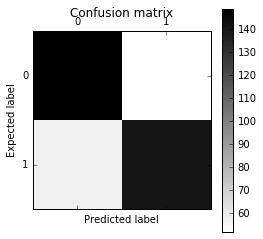

In [14]:
train_benchmark_and_save(
    simple_features(data_train, data_test), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

##### Distintos tipos de Features nuestros

Extracting features from the training data using a BagOfWordsSparseVectorizer
Done in 0.678000s
Extracting features from the training data using the same BagOfWordsSparseVectorizer
Done in 0.136000s

Training Set: 1598 samples 64781 features
Test     Set: 400 samples 64781 features

Fitting a DecisionTree Classifier
Done in 0.022000s

Running Test Score on DecisionTree
Done in 0.000000s
Test Score:   1.000000
Classification report:
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       201
       spam       1.00      1.00      1.00       199

avg / total       1.00      1.00      1.00       400



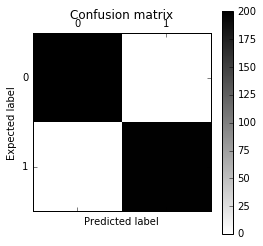

In [15]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'count', use_custom_tokenizer=False), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

Extracting features from the training data using a TfIdfSparseVectorizer
Done in 0.665000s
Extracting features from the training data using the same TfIdfSparseVectorizer
Done in 0.142000s

Training Set: 1598 samples 2426 features
Test     Set: 400 samples 2426 features

Fitting a DecisionTree Classifier
Done in 0.011000s

Running Test Score on DecisionTree
Done in 0.000000s
Test Score:   1.000000
Classification report:
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       201
       spam       1.00      1.00      1.00       199

avg / total       1.00      1.00      1.00       400



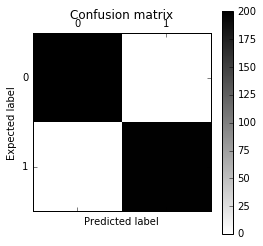

In [16]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'tfidf', use_custom_tokenizer=False, sublinear_tf=True, min_df=0.01, max_df=0.7), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

Extracting features from the training data using a HashingBagOfWordsSparseVectorizer
Done in 0.634000s
Extracting features from the training data using the same HashingBagOfWordsSparseVectorizer
Done in 0.160000s

Training Set: 1598 samples 262144 features
Test     Set: 400 samples 262144 features

Fitting a DecisionTree Classifier
Done in 0.128000s

Running Test Score on DecisionTree
Done in 0.001000s
Test Score:   1.000000
Classification report:
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       201
       spam       1.00      1.00      1.00       199

avg / total       1.00      1.00      1.00       400



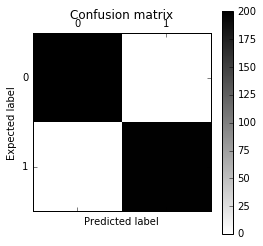

In [17]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'hashing', use_custom_tokenizer=False, non_negative=True, n_features=2 ** 18), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

Extracting features from the training data using a BagOfWordsSparseVectorizer
Done in 9.785000s
Extracting features from the training data using the same BagOfWordsSparseVectorizer
Done in 2.051000s

Training Set: 1598 samples 69117 features
Test     Set: 400 samples 69117 features

Fitting a DecisionTree Classifier
Done in 0.022000s

Running Test Score on DecisionTree
Done in 0.000000s
Test Score:   1.000000
Classification report:
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       201
       spam       1.00      1.00      1.00       199

avg / total       1.00      1.00      1.00       400



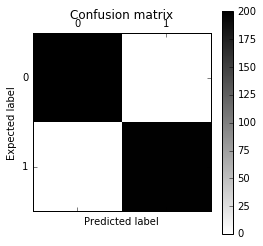

In [18]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'count', use_custom_tokenizer=True), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

Extracting features from the training data using a TfIdfSparseVectorizer
Done in 8.461000s
Extracting features from the training data using the same TfIdfSparseVectorizer
Done in 2.097000s

Training Set: 1598 samples 2332 features
Test     Set: 400 samples 2332 features

Fitting a DecisionTree Classifier
Done in 0.012000s

Running Test Score on DecisionTree
Done in 0.000000s
Test Score:   1.000000
Classification report:
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       201
       spam       1.00      1.00      1.00       199

avg / total       1.00      1.00      1.00       400



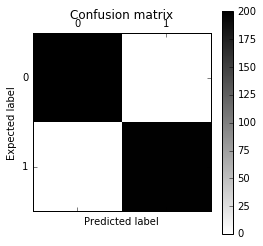

In [19]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'tfidf', use_custom_tokenizer=True, sublinear_tf=True, min_df=0.01, max_df=0.7), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))

Extracting features from the training data using a HashingBagOfWordsSparseVectorizer
Done in 8.497000s
Extracting features from the training data using the same HashingBagOfWordsSparseVectorizer
Done in 2.121000s

Training Set: 1598 samples 262144 features
Test     Set: 400 samples 262144 features

Fitting a DecisionTree Classifier
Done in 0.128000s

Running Test Score on DecisionTree
Done in 0.001000s
Test Score:   1.000000
Classification report:
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       201
       spam       1.00      1.00      1.00       199

avg / total       1.00      1.00      1.00       400



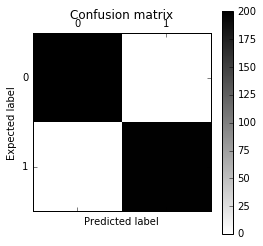

In [20]:
train_benchmark_and_save(
    vectorizer_features(data_train, data_test, 'hashing', use_custom_tokenizer=True, non_negative=True, n_features=2 ** 18), 
    (DecisionTreeClassifier(), 'DecisionTree'), 
    (data_train, data_test))